<a href="https://colab.research.google.com/github/blue-create/langlens/blob/main/scripts/elinor_export.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Purpose

This file shows the steps we took to sample and create the annotation dataset.

## Connect with Google drive to access data 

In order to access the data, you first need to create a shortcut of the data folder to your own Gdrive. If you've been granted editing rights, you should be able to edit the content of the folder, i.e. add, move and delete data, create and rename folders, etc.

In [1]:
# connect with google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# redirect the working directory of this script to the data folder
%cd /content/drive/MyDrive/data/

/content/drive/MyDrive/data


## Load data

### Method 1: get csv files 

In [56]:
import tqdm as tqdm
import os
import pandas as pd
import re 

folder_path = "filtered2"

In [ ]:
dfs = []

# loop through files 
for filename in os.listdir(folder_path):
    # if csv file, load and add to dfs  
    if filename.endswith(".csv"):
        file_path = os.path.join(folder_path, filename)
        df = pd.read_csv(file_path)
        dfs.append(df)

# combine files in df
df = pd.concat(dfs, ignore_index=True)

### Method 2: get a csv file

In [96]:
import tqdm as tqdm
import os
import pandas as pd

df_subset = pd.read_csv('sample.csv', encoding='utf-8')

## Inspect data


In [98]:
df_subset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  50 non-null     int64 
 1   artikel_id  50 non-null     object
 2   name        50 non-null     object
 3   jahrgang    50 non-null     int64 
 4   datum       50 non-null     int64 
 5   ressort     48 non-null     object
 6   titel       50 non-null     object
 7   untertitel  22 non-null     object
 8   text        50 non-null     object
dtypes: int64(3), object(6)
memory usage: 3.6+ KB


In [99]:
# remove first column 
df_subset1 = df_subset.drop("Unnamed: 0", axis=1)

## Create a random subset of the data 

In [ ]:
# size of subset we want 
number = 100

In [ ]:
perc = number/df1.shape[0]
df_subset = df1.sample(frac=perc, random_state=42)

In [ ]:
df_subset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 141433 to 1157830
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   artikel_id  100 non-null    object 
 1   name        100 non-null    object 
 2   jahrgang    100 non-null    object 
 3   datum       100 non-null    float64
 4   ressort     89 non-null     object 
 5   titel       92 non-null     object 
 6   untertitel  37 non-null     object 
 7   text        100 non-null    object 
dtypes: float64(1), object(7)
memory usage: 7.0+ KB


## Adjust format for export

### String fixes 

In [100]:
# remove square brackets 
df_subset1["text"] = df_subset1["text"].apply(lambda x: x[1:-1] if (isinstance(x, str) and x.startswith("[") and x.endswith("]")) else x)
# remove backward slashes
df_subset1['text'] = df_subset1['text'].str.replace('\\', '', regex = False)
# remove genios styles
df_subset1["text"] = df_subset1["text"].apply(lambda x: re.sub(r'<.*?>', '', x))

In [101]:
# function to split strings to list
def split_to_list(s):
    return s.split("', '")

In [102]:
# apply function to whole column
df_subset1['text'] = df_subset1['text'].apply(split_to_list)

In [103]:
# add new line to separate paragraphs 
df_subset1['text'] = df_subset1['text'].apply(lambda x: [char+'\n' for char in x])

### Explode by paragraphs

In [158]:
# Explode "text" column
df_elinor = df_subset1.explode("text")

# Filter out paragraphs with less than 5 words
df_elinor1 = df_elinor[df_elinor["text"].apply(lambda x: len(x.split()) >= 5)]

# Create "artikel_order" column
df_elinor1["artikel_order"] = df_elinor1.groupby("artikel_id").cumcount() + 1


<ipython-input-158-bed3ffa0ab5a>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_elinor1["artikel_order"] = df_elinor1.groupby("artikel_id").cumcount() + 1


### Get length of paragraphs

In [159]:
import statistics

# function to count sentences and get summary statistics
def count_sentences(paragraphs):
    sentence_counts = [len(paragraph.split('.')) for paragraph in paragraphs]
    return {'mean': statistics.mean(sentence_counts),
            'max': max(sentence_counts),
            'min': min(sentence_counts),
            'mode': statistics.mode(sentence_counts)}

In [171]:
summary = count_sentences(df_elinor1['text'])
print("Sentence length:", summary)

Sentence length: {'mean': 5.352941176470588, 'max': 49, 'min': 1, 'mode': 4}


<ipython-input-173-9189162aad6e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_elinor1['num_sentences'] = df_elinor1['text'].apply(lambda x: len(x))


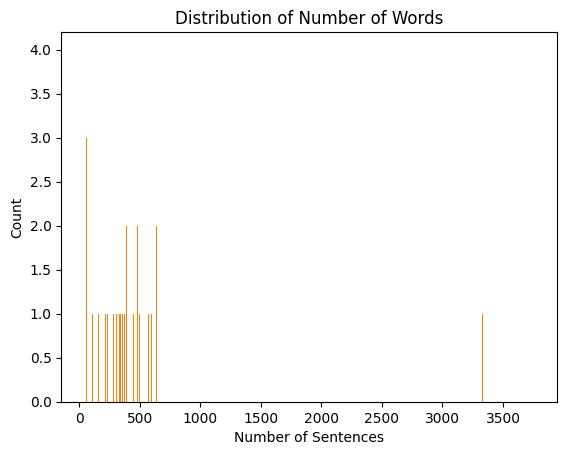

In [173]:
import matplotlib.pyplot as plt

# Get word length
df_elinor1['num_sentences'] = df_elinor1['text'].apply(lambda x: len(x))

# Create a bar chart
plt.bar(df_elinor1['num_sentences'].unique(), df_elinor1['num_sentences'].value_counts())

# Create a bar chart
plt.bar(df_elinor1['num_sentences'].unique(), df_elinor1['num_sentences'].value_counts())

# Set axis labels and title
plt.xlabel('Number of Sentences')
plt.ylabel('Count')
plt.title('Distribution of Number of Words')

# Show the plot
plt.show()

### Inspect paragraphs by length

In [177]:
df_elinor1['num_sentences'] = df_elinor1['text'].apply(lambda x: len(x))
df_subset_length = df_elinor1[df_elinor1['num_sentences'] < 1000]


<ipython-input-177-87e1ef3145aa>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_elinor1['num_sentences'] = df_elinor1['text'].apply(lambda x: len(x))


In [ ]:
for row in df_subset_length['text']:
  print(row)

### Randomly select one paragraph per article

In [183]:
# function to randomly select one row
def random_select(group):
    return group.sample(n=1, random_state=1)


In [184]:
# Apply function to randomly select one row per unique artikel_id
df_elinor2 = df_elinor1.groupby("artikel_id").apply(random_select).reset_index(drop=True)


In [185]:
len(df_elinor2)

50

In [108]:
df_elinor3 = df_elinor2[['text']]

## Export as csv

In [109]:
output_path = "elinor"

In [111]:
df_elinor3.to_csv(output_path+"/annotation_test3.csv", index=False, header = True,
                  encoding = 'utf-8',
                  sep="\t")